In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from hyperparam_scan_util import _load_trial_dict_and_epoch_dicts_from_path

trial_dict, epoch_dicts = _load_trial_dict_and_epoch_dicts_from_path(
    "results/test_runs/v2.1_first_spike_time_best/results.yaml"
)
epochs_df = pd.DataFrame(epoch_dicts)

config = {
    key.removeprefix("config."): value
    for key, value in trial_dict.items()
    if key.startswith("config.")
}

metrics = {
    key.removeprefix("metrics."): value
    for key, value in trial_dict.items()
    if key.startswith("metrics.")
}

epochs_df

,acc_mean,acc_std,acc_ord_mean,acc_ord_std,activity_mean,activity_std,activity_first_mean,activity_first_std,activity_out_mean,activity_out_std,...,train_loss_ord_std,train_out_val_false_mean,train_out_val_false_std,train_out_val_true_mean,train_out_val_true_std,train_silent_neurons_mean,train_silent_neurons_std,train_silent_neurons_first_mean,train_silent_neurons_first_std,epoch
0,0.056184,0.008189,0.056184,0.008189,2.076460,0.068960,1.140918,0.073819,2.26400,0.000000,...,0.002801,35.543987,0.001207,35.543369,0.003598,0.000000,0.000000,0.009375,0.003125,0
1,0.224735,0.019321,0.224735,0.019321,2.729502,0.098335,1.683325,0.058778,2.26400,0.000000,...,0.037140,36.915722,0.166364,34.818283,0.099730,0.120313,0.025000,0.325000,0.011693,1
2,0.360071,0.042595,0.360071,0.042595,2.660899,0.118365,1.717806,0.080346,2.21825,0.008789,...,0.066870,40.296490,0.440356,34.656868,0.114209,0.146094,0.025746,0.318750,0.010066,2
3,0.422085,0.020586,0.422085,0.020586,2.687895,0.152448,1.795680,0.107689,2.11068,0.028898,...,0.042081,44.462971,1.072098,35.200409,0.301524,0.167969,0.024332,0.317188,0.012451,3
4,0.490194,0.022670,0.490194,0.022670,2.657046,0.156112,1.798228,0.102377,2.01428,0.035367,...,0.022018,47.743004,1.107541,35.587868,0.262008,0.185156,0.019232,0.317969,0.008414,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.733481,0.005570,0.705654,0.015890,2.467690,0.125730,2.168133,0.140207,0.48876,0.038087,...,0.045382,92.506126,1.976697,50.078915,1.066287,0.302344,0.020010,0.326562,0.017918,96
97,0.732686,0.009359,0.701767,0.019171,2.466952,0.131885,2.165563,0.145398,0.48481,0.035019,...,0.066072,92.487663,1.646236,50.102840,1.101127,0.305469,0.019359,0.327344,0.018717,97
98,0.727297,0.012925,0.689488,0.012415,2.472738,0.133873,2.177571,0.142427,0.46821,0.036977,...,0.061340,92.915672,1.482730,50.273716,1.035310,0.306250,0.020758,0.328125,0.018815,98
99,0.731360,0.009618,0.700442,0.012130,2.468188,0.127937,2.166703,0.125356,0.47957,0.024708,...,0.038124,92.622482,2.207688,50.042633,0.601376,0.305469,0.018388,0.327344,0.017188,99


In [2]:
from spikegd.utils.formatting import fmt_number, fmt_number_with_error, print_dict

print("CONFIG")
print_dict(
    {f"- {k}": v for k, v in config.items()}
)
print("METRICS")

def summarize_metric(mean_key):
    std_key = mean_key.replace("_mean", "_std")
    epoch_key = mean_key.replace("_mean", "_epoch")

    if std_key in trial_dict:
        s = fmt_number_with_error(trial_dict[mean_key], trial_dict[std_key])
    else:
        s = fmt_number(trial_dict[mean_key])

    if epoch_key in trial_dict:
        s += f" at epoch {trial_dict[epoch_key]:.0f}"

    return s

print_dict(
    {
        "- " + key.removeprefix("metrics.").removesuffix("_mean"): summarize_metric(key)
        for key, value in trial_dict.items()
        if key.startswith("metrics.") and key.endswith("_mean")
    },
    indent=32,
)

CONFIG
- device_count            1
- seed                    0
- I0                      1.25
- eps                     1e-06
- Nin_virtual             16
- Nhidden                 128
- Nout                    20
- w_scale                 0.5
- K                       700
- dt                      0.001
- Nbatch                  1000
- lr                      0.004
- tau_lr                  100
- beta1                   0.9
- beta2                   0.999
- p_flip                  0
- Nepochs                 100
- Ntrain                  None
- Nin                     700
- Nsamples                5
- normalize_times         1
- tau                     22.6
- Nlayer                  3
- T                       64
- gamma                   0.001
- out_func                first_spike_time
METRICS
- acc_init                      0.0562 ± 0.0082
- acc_final                     0.7376 ± 0.0070
- acc_min                       0.0562 ± 0.0082 at epoch 0
- acc_max                       0.7376

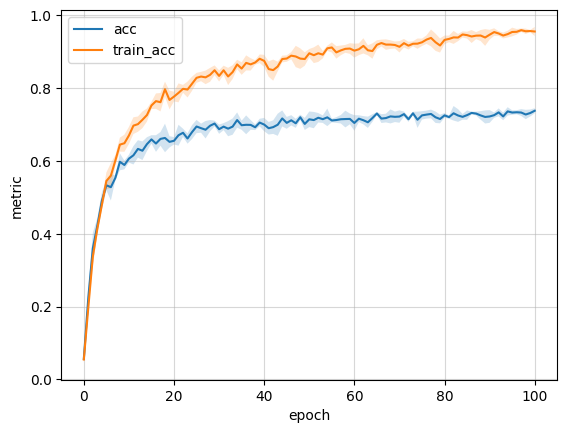

In [3]:
epochs = np.arange(len(epochs_df))

fig, ax = plt.subplots()

for metric in ["acc", "train_acc"]:
    mean_arr = epochs_df[f"{metric}_mean"]
    std_arr = epochs_df[f"{metric}_std"]

    na_count = np.isnan(mean_arr).sum()
    if na_count > 0:
        print(f"Warning: {na_count} NaN values in {metric}_mean")

    ax.plot(epochs, mean_arr, label=metric)
    ax.fill_between(epochs, mean_arr - std_arr, mean_arr + std_arr, alpha=0.2)

ax.set_xlabel("epoch")
ax.set_ylabel("metric")
ax.grid(alpha=0.5)
ax.legend()

plt.show()

## Simulate

In [4]:
import pickle

with open("test_params.pickle", "rb") as file:
    params = pickle.load(file)

assert isinstance(params, list)

print(f"Found params for {len(params)} samples")
print(f"Keys: {list(params[0].keys())}")

Found params for 5 samples
Keys: ['init', 'final', 'best_acc', '_meta']


In [5]:
from tqdm import tqdm

from heidelberg_v02_more_metrics import load_data, load_datasets, run_theta_example
from spikegd.utils.formatting import fmt_intersection

print("Loading data...")
datasets = load_datasets("data")
_, test_dataloader = load_data(datasets, config)
test_dataset = test_dataloader.dataset

sample_params = params[0].copy()
assert isinstance(sample_params, dict)
params_meta = sample_params.pop("_meta")

sample_indices = range(8)
print(
    f"Simulating examples {fmt_intersection(sample_params.keys(), repr)} "
    f"for data samples {sample_indices}..."
)

example_list = [
    {
        name: run_theta_example(
            test_dataset, param_arr, config, sample_index=sample_index
        )
        for name, param_arr in sample_params.items()
    }
    for sample_index in tqdm(sample_indices)
]

Loading data...
Simulating examples 'init', 'final' and 'best_acc' for data samples range(0, 8)...


100%|██████████| 8/8 [02:29<00:00, 18.68s/it]


## Spike trains

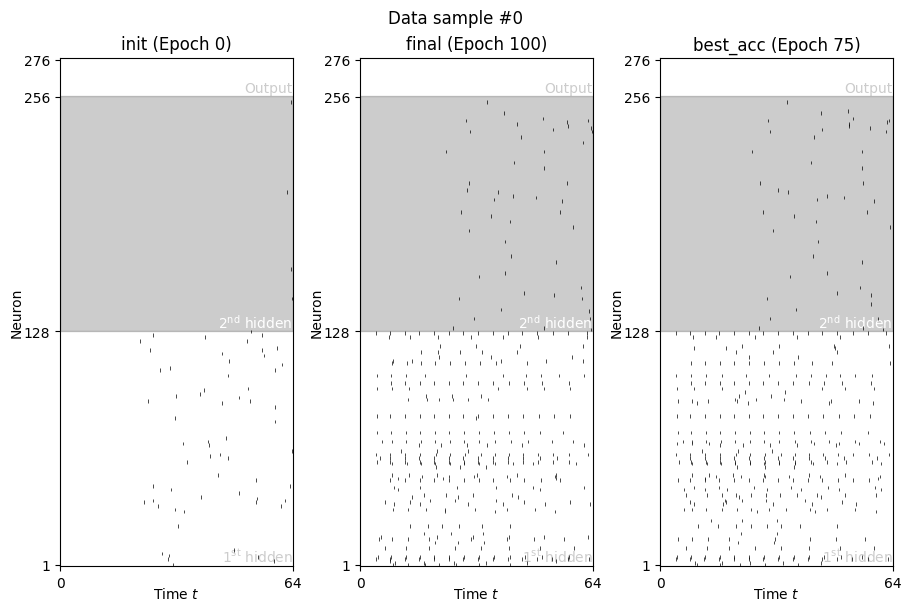

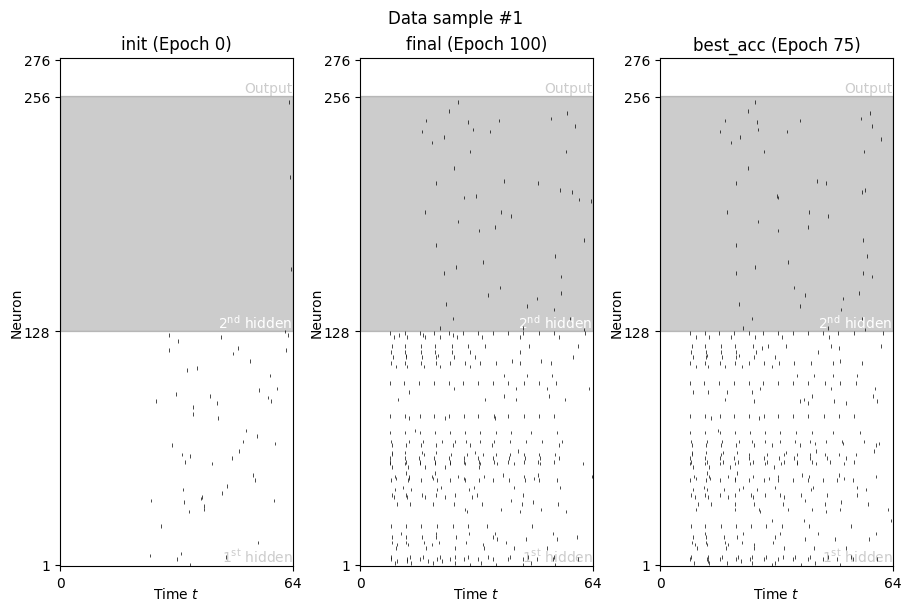

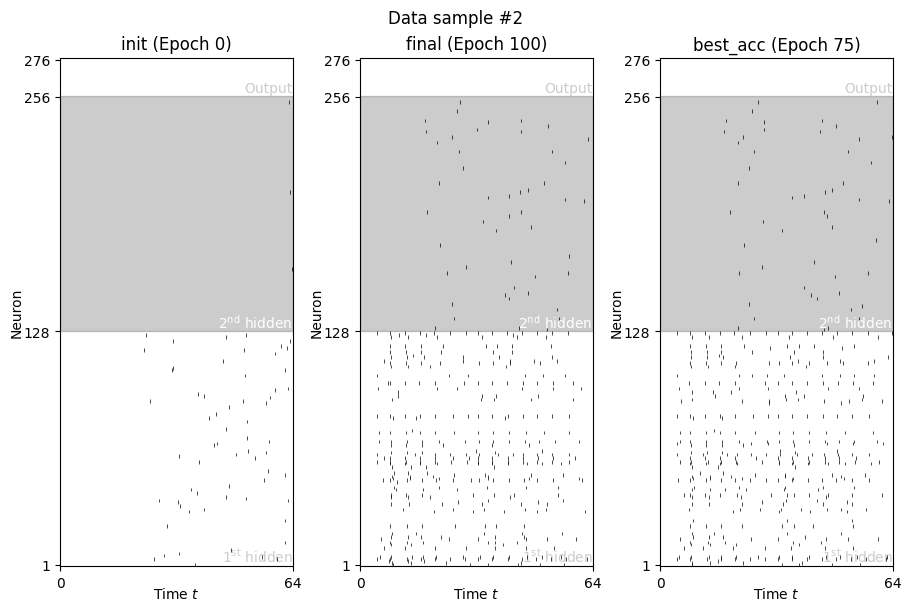

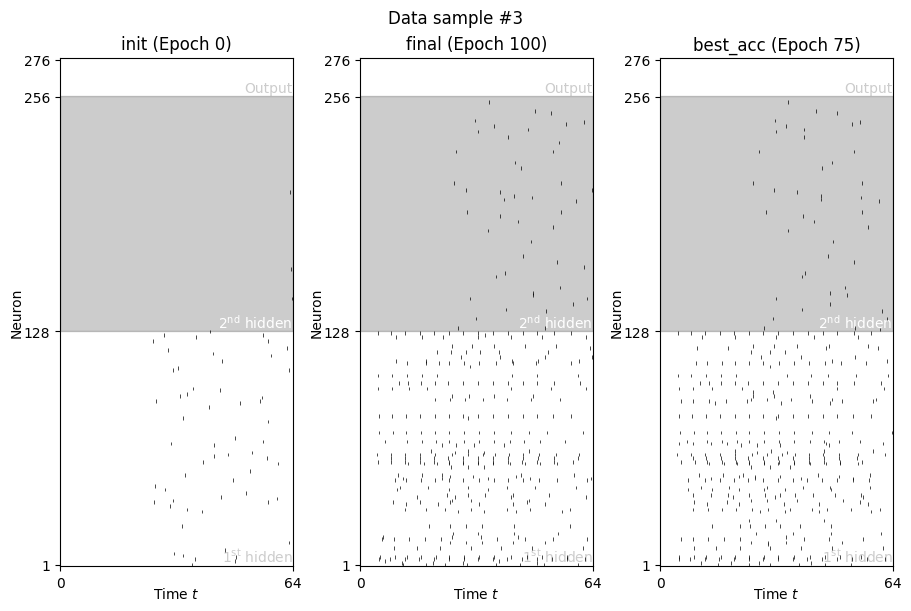

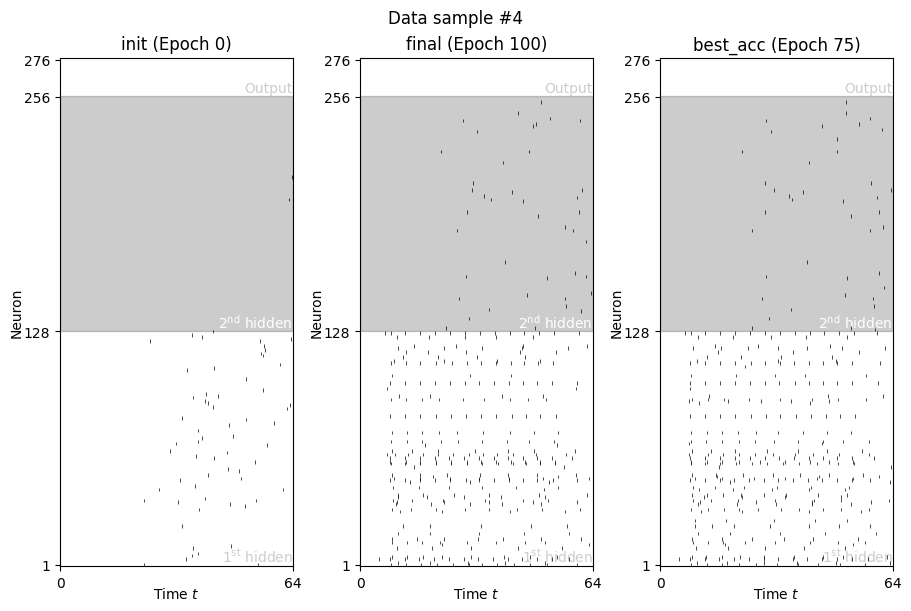

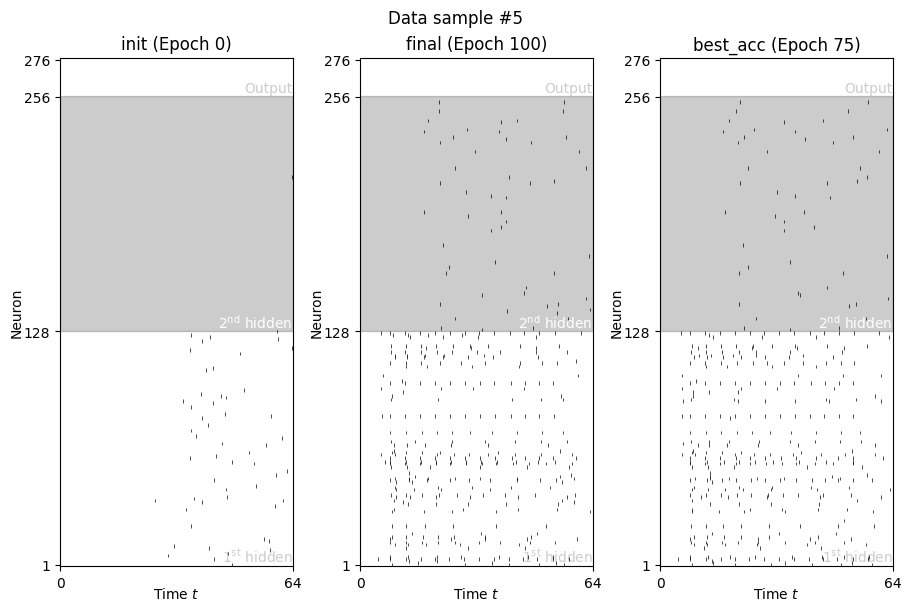

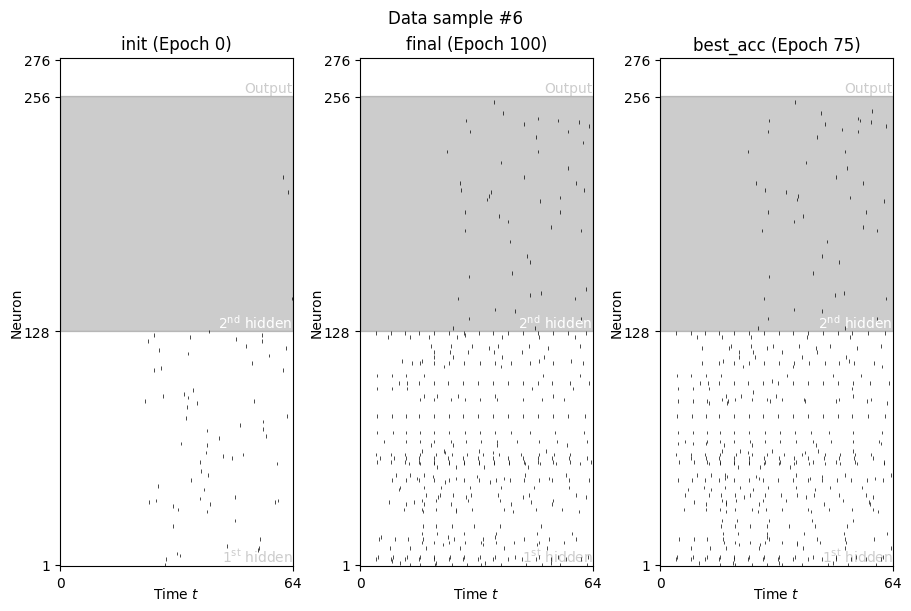

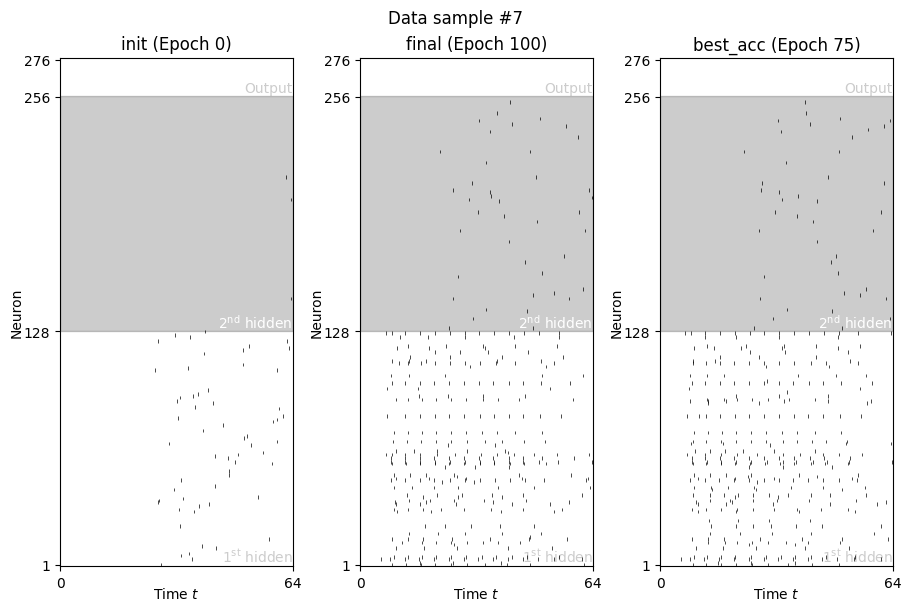

In [6]:
from heidelberg_v02_more_metrics import plot_spikes

for sample_index, examples in zip(sample_indices, example_list):
    fig, axs = plt.subplots(1, len(examples), figsize=(3 * len(examples), 6),
                            constrained_layout=True)
    
    fig.suptitle(f"Data sample #{sample_index}")

    for ax, (name, example) in zip(axs, examples.items()):
        plot_spikes(ax, example, config)
        epoch = params_meta["epochs"][name]
        ax.set_title(f"{name} (Epoch {epoch})")

    plt.show()

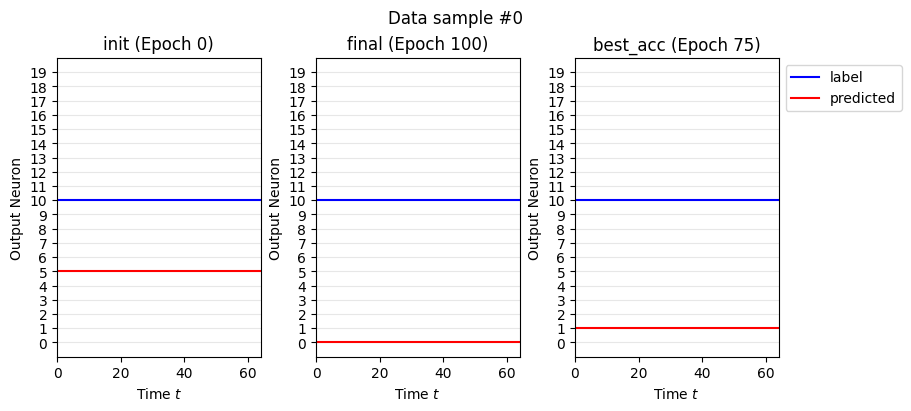

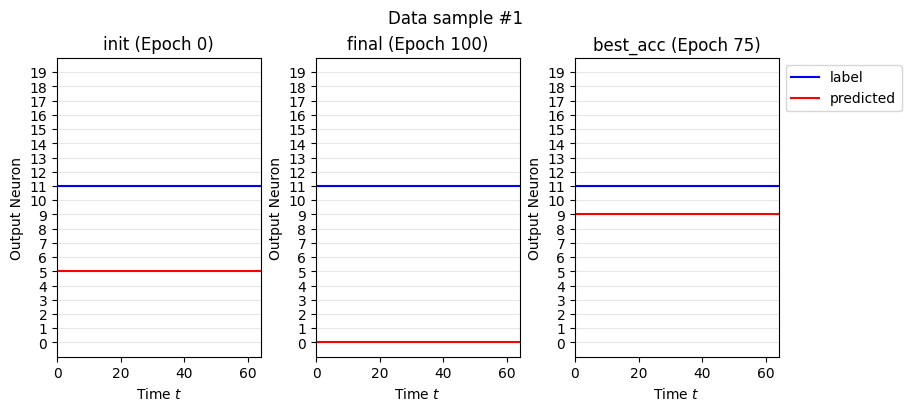

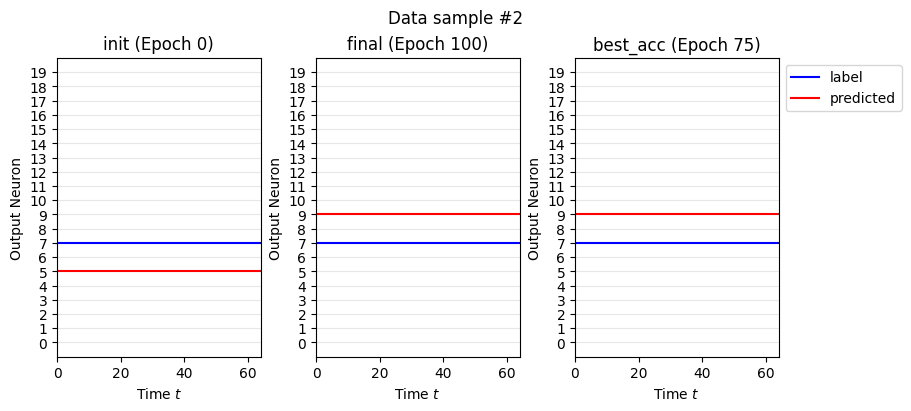

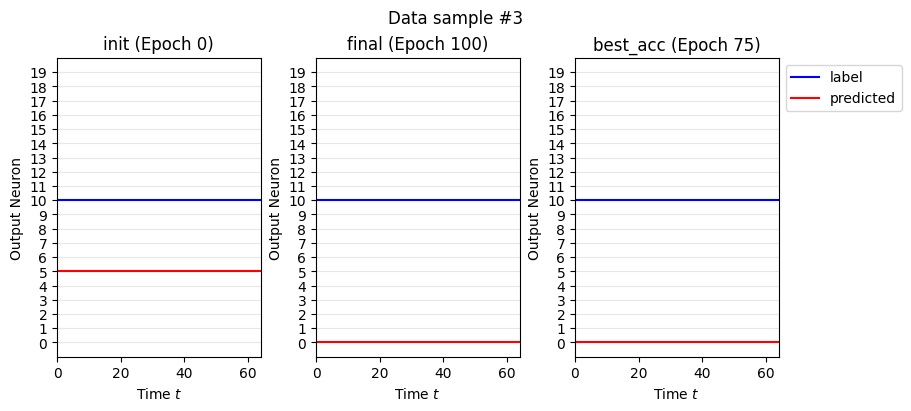

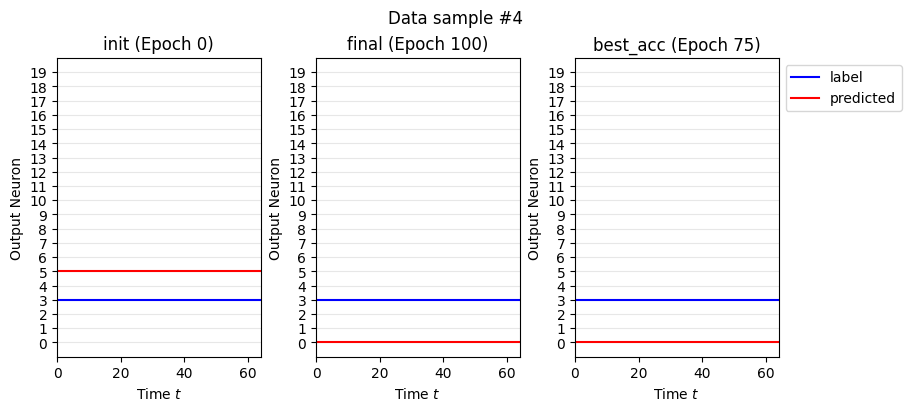

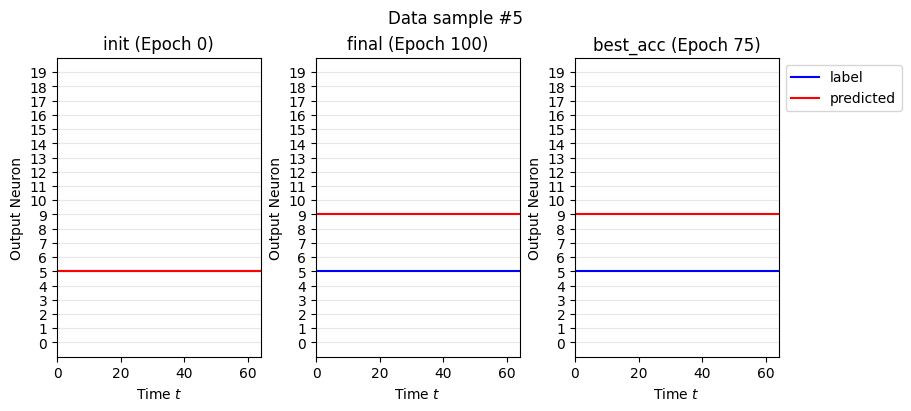

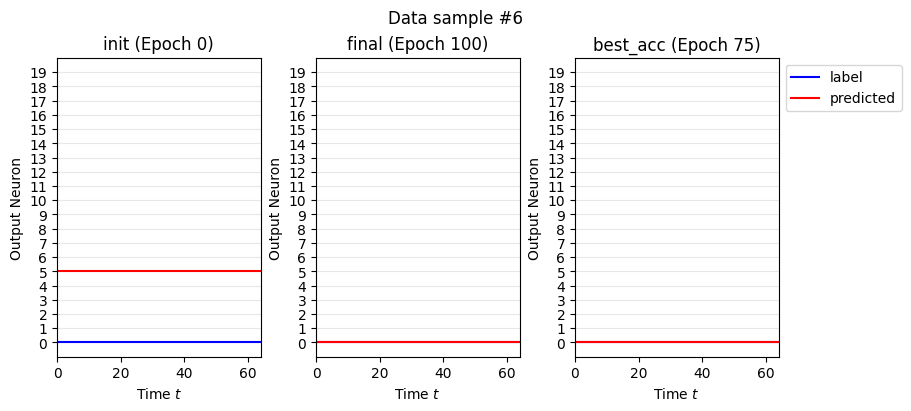

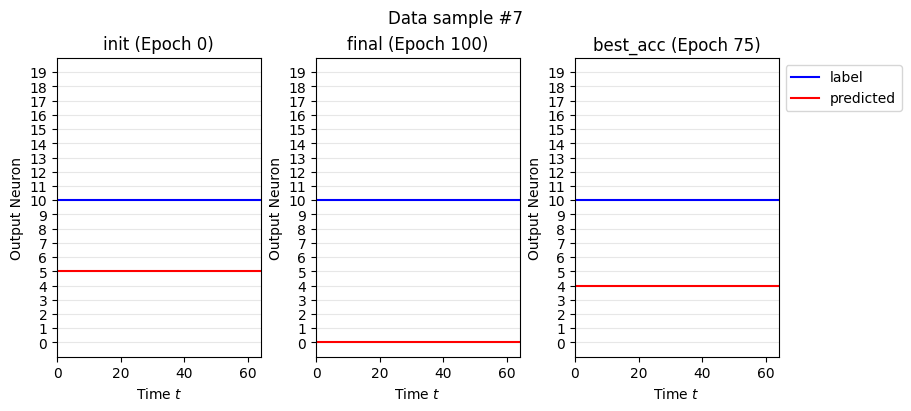

In [7]:
from jax import Array
from matplotlib.axes import Axes

def plot_output_spikes(ax: Axes, example: dict, config: dict) -> None:
    ### Unpack arguments
    T: float = config["T"]
    Nhidden: int = config["Nhidden"]
    Nlayer: int = config["Nlayer"]
    Nout: int = config["Nout"]
    N = (Nlayer - 1) * Nhidden + Nout
    spiketimes: Array = example["spiketimes"]

    spiketimes = spiketimes[N - Nout :]
    
    ### Plot spikes
    tick_len = 0.8
    ax.eventplot(spiketimes, colors="k", linewidths=0.5, linelengths=tick_len)

    ### Formatting
    ax.set_xlim(0, T)
    ax.set_xlabel("Time $t$")
    ax.set_yticks(
        range(Nout)
    )
    ax.set_ylim(-1, Nout)
    ax.set_ylabel("Output Neuron")
    ax.grid(alpha=0.3, axis="y")

for sample_index, examples in zip(sample_indices, example_list):    
    fig, axs = plt.subplots(1, len(examples), figsize=(3 * len(examples), 4),
                            constrained_layout=True)

    fig.suptitle(f"Data sample #{sample_index}")

    for ax, (name, example) in zip(axs, examples.items()):
        plot_output_spikes(ax, example, config)
        epoch = params_meta["epochs"][name]
        ax.set_title(f"{name} (Epoch {epoch})")
        label = example["label"]
        predicted = example["predicted"]
        ax.axhline(label, label="label", color="blue")
        ax.axhline(predicted, label="predicted", color="red")

    axs[-1].legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()